In [1]:
# imports
from commstools.core import Signal
from commstools.mapping import gray_constellation
from commstools.logger import set_log_level
from commstools.plotting import ideal_constellation

set_log_level("WARNING")


2026-02-10 18:32:09 [INFO] [commstools/backend.py] CuPy is available and functional, defaulting Signals to GPU.


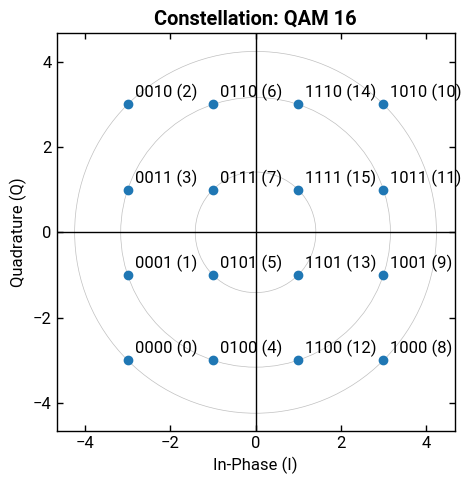

In [17]:
ideal_constellation(modulation="qam", order=16, show=True)


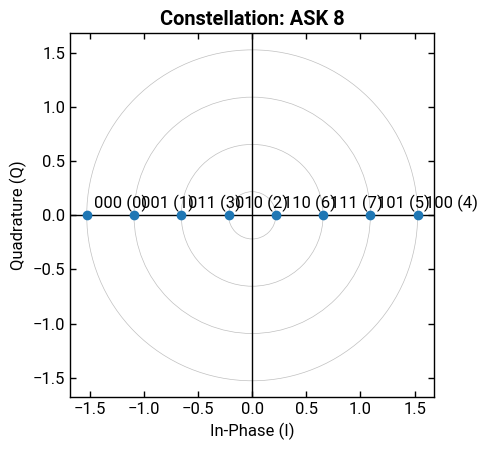

In [15]:
ideal_constellation(modulation="ask", order=8, show=True, normalize=True)
